# Exploratory Weather Data Analysis
This analysis will use daily weather data created in [part one](#) and will focus on:

1. Quantifying the "missingness" of weather and precipitation measurements
2. Exploring relationships between weather and precipitation variables
3. Visualizing how weather and precipitation are changing over time

As this is an EDA (exploratory data analysis), emphasis will be placed on graphical rather than statisical representations of the data in the hopes (and expectation) that readers will be able to better identify better with the data through visualization than with the raw numbers.

In [1]:
from datetime import datetime
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import itertools
import chartify
warnings.filterwarnings('ignore')
%matplotlib inline

ModuleNotFoundError: No module named 'missingno'

## Data

In [2]:
df = pd.read_csv('../data/processed/daily-weather-data.csv', parse_dates=['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3407 entries, 0 to 3406
Data columns (total 9 columns):
date             3407 non-null datetime64[ns]
totalPrecipMM    3361 non-null float64
minTemp          3407 non-null float64
maxTemp          3406 non-null float64
meanTemp         3406 non-null float64
totalSnowCM      1109 non-null float64
season           3407 non-null object
year             3407 non-null int64
month            3407 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 239.6+ KB
None


,date,totalPrecipMM,minTemp,maxTemp,meanTemp,totalSnowCM,season,year,month
0,2010-01-01,4.9,-9.2,0.0,-4.6,15.0,winter,2010,1
1,2010-01-02,4.1,-14.1,-9.2,-11.7,6.0,winter,2010,1
2,2010-01-03,1.1,-12.6,-5.6,-9.1,1.0,winter,2010,1
3,2010-01-04,0.5,-11.2,-7.5,-9.4,1.0,winter,2010,1
4,2010-01-05,0.0,-8.9,-3.5,-6.2,NaN,winter,2010,1


In [3]:
df['date'].describe()

count                    3407
unique                   3407
top       2015-10-18 00:00:00
freq                        1
first     2010-01-01 00:00:00
last      2019-04-30 00:00:00
Name: date, dtype: object

## Missing Values

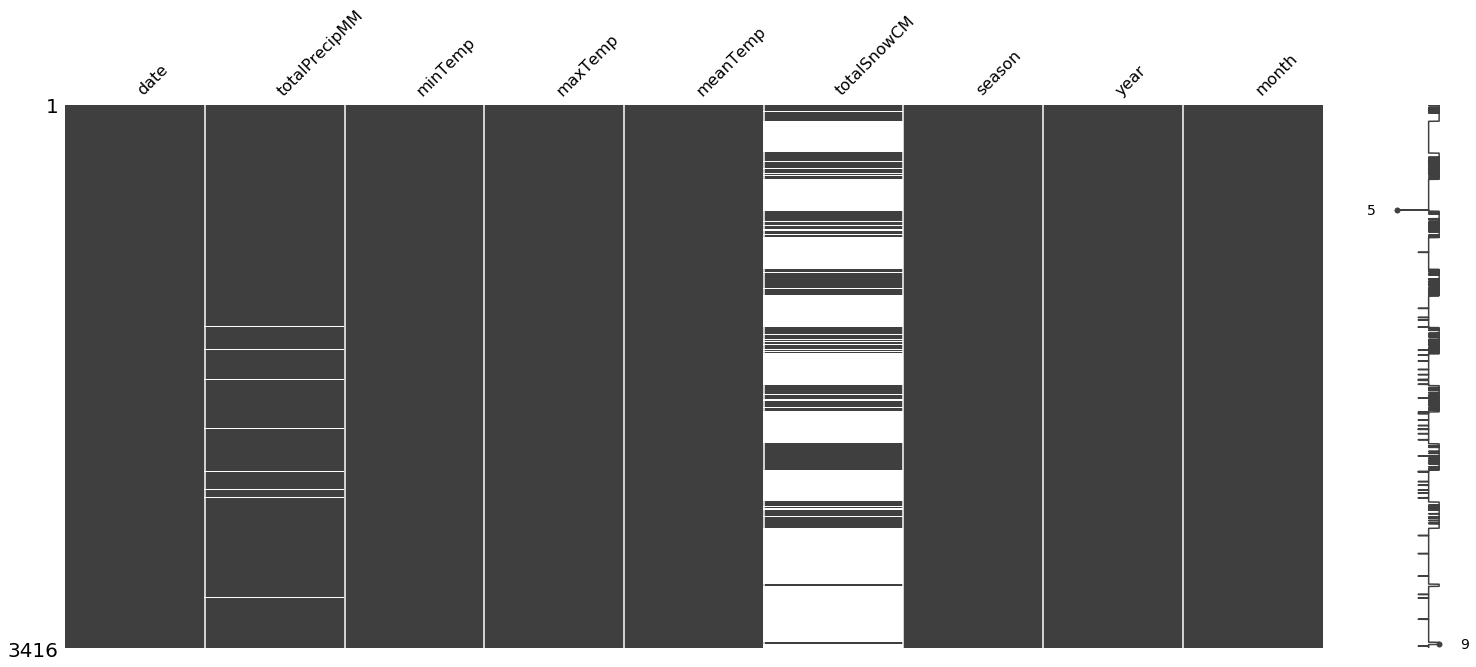

In [4]:
msno.matrix(df.sort_values('date', ascending=True));

Summary statistics for missing values:

In [5]:
max_missing_vars = df.isnull().sum(axis=1).sort_values(ascending=False).values[0]
max_missing_day = df.loc[df.isnull().sum(axis=1).sort_values(ascending=False).head(1).index, 'date'].values[0]
n_missing_precip = df.totalPrecipMM.isnull().sum()

print("Number of variables: %s" % len(df.columns))
print("Highest number of variables missing a value: {}".format(max_missing_vars))
print("Day with highest number of variables missing a value: %s" % pd.to_datetime(max_missing_day).date())
print("Number of days missing precipitation: {}".format(n_missing_precip))

Number of variables: 9
Highest number of variables missing a value: 4
Day with highest number of variables missing a value: 2011-10-24
Number of days missing precipitation: 46


Which months are missing the most precipitation measurements?

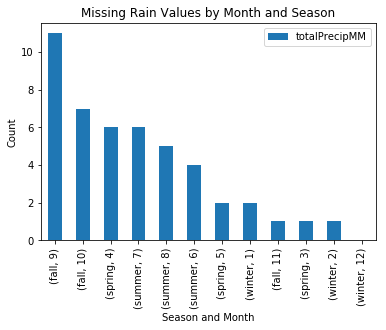

In [6]:
missing_df = df[['month', 'season', 'totalPrecipMM']].groupby(
  ['season', 'month'])[['totalPrecipMM']].apply(lambda x: pd.isnull(x).sum())
missing_df.sort_values('totalPrecipMM', ascending=False).plot(kind='bar').set(
  title='Missing Rain Values by Month and Season',
  xlabel='Season and Month',
  ylabel='Count');

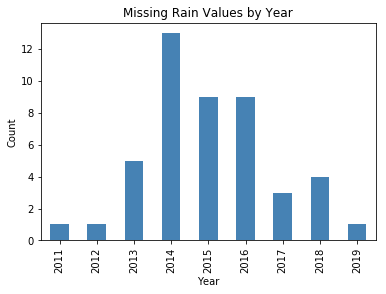

In [7]:
df[df.totalPrecipMM.isnull()].groupby(
  ['year']).size().plot(kind='bar', color='steelblue').set(
  title='Missing Rain Values by Year',
  xlabel='Year',
  ylabel='Count');

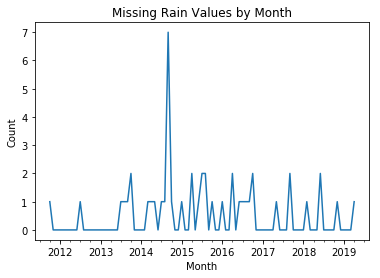

In [8]:
df[df.totalPrecipMM.isnull()].set_index('date').resample('1M').size().plot().set(
  title='Missing Rain Values by Month',
  xlabel='Month',
  ylabel='Count');

Missing precipitation readings has been reduced substationally over the last couple of years and the number of missing observations in any given month is small (generally 2 or less missing observations per month). Since we don't see the missing values having any significant impact on our analysis, we'll keep them in the dataset.

## How much rain is expected daily?

### Distribution

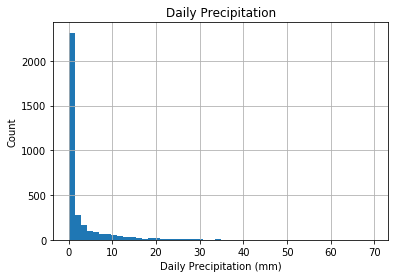

In [9]:
df.totalPrecipMM.hist(bins=50).set(
  title='Daily Precipitation',
  xlabel='Daily Precipitation (mm)',
  ylabel='Count');

Looks like there are lots of observations where $totalPrecipMM=0$ which is to be expected. What is the proportion of days with observed precipitation?

In [10]:
len(df.query('totalPrecipMM > 0')) / len(df)

0.5040983606557377

Intuitively, we wouldn't expect that it rains 50% of the time. There are likely a lot of days with trace amounts of precipitation. We can use the guidelines provided in [1] for a more meaningful definition of rain.

In [11]:
len(df.query('totalPrecipMM >= 0.2')) / len(df)

0.4774590163934426

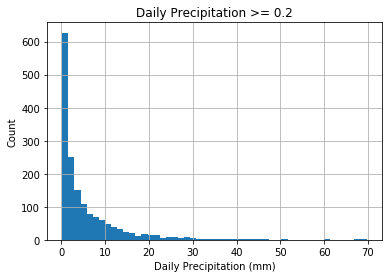

In [108]:
rainy_days = df.query('totalPrecipMM >= 0.2')
rainy_days.totalPrecipMM.hist(bins=50).set(
  title='Daily Precipitation >= 0.2',
  xlabel='Daily Precipitation (mm)',
  ylabel='Count');

In [13]:
rainy_days['totalPrecipMM'].describe()

count    1631.000000
mean        5.541907
std         7.640348
min         0.200000
25%         0.850000
50%         2.550000
75%         7.300000
max        69.700000
Name: totalPrecipMM, dtype: float64

As we noted in the station analysis notebook, precipitation is known to follow a gamma distribution. 50% of the observations have an observed daily precipitation total of 2.55mm or less and 75% have an observed precipitation valueo of 7.3mm or less. The most observed rain was 69.7mm.

Rain intensity is defined using hourly rates [1] which is not available with daily precipitation data since rain will not be uniformly distributed over each hour in a day - simply dividing an observation by 24 would result in very low rates and only the most extreme observations (the three observations greater than 60mm) would be considered "light rain" since $\frac{60}{24}=2.5$. To compute an hourly rate we could use hourly data available from [2] for the Airport and CS stations or compute the n-index and resulting intensities as described in [3]. 

Rather than incurring the additional work, we can look more closely at the distribution of daily precipitation levels to start to classify / bucket rainfall. 

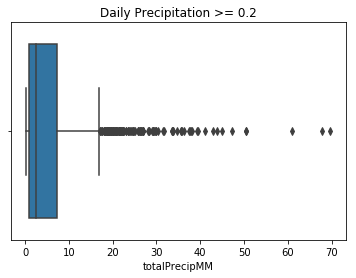

In [109]:
sns.boxplot(rainy_days['totalPrecipMM']).set(title='Daily Precipitation >= 0.2');

Let's look at different parts of the distribution to understand different precipitation levels.

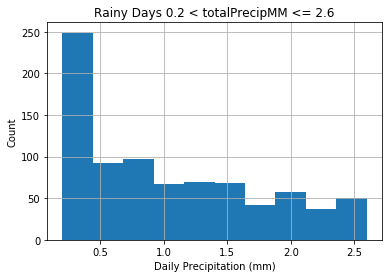

In [111]:
rainy_days.query('totalPrecipMM <= 2.6')['totalPrecipMM'].hist().set(
  title='Rainy Days 0.2 < totalPrecipMM <= 2.6',
  xlabel='Daily Precipitation (mm)',
  ylabel='Count'
);

Precipitation level fairly uniform over the lower range.

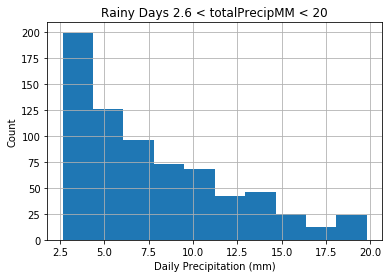

In [112]:
rainy_days.query('(totalPrecipMM > 2.6) & (totalPrecipMM < 20)')['totalPrecipMM'].hist().set(
  title='Rainy Days 2.6 < totalPrecipMM < 20',
  xlabel='Daily Precipitation (mm)',
  ylabel='Count'
);

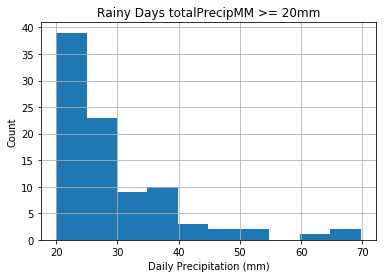

In [113]:
rainy_days.query('totalPrecipMM >= 20')['totalPrecipMM'].hist().set(
  title='Rainy Days totalPrecipMM >= 20mm',
  xlabel='Daily Precipitation (mm)',
  ylabel='Count'
);

In [114]:
len(rainy_days.query('totalPrecipMM > 20')) / len(rainy_days)

0.054567749846719804

In [115]:
len(rainy_days.query('totalPrecipMM > 30')) / len(rainy_days)

0.017167381974248927

Rainy days with at least 30mm of precipitation is rare. When were the outliers observed?

In [116]:
rainy_days.query('totalPrecipMM > 30').groupby(['season', 'month', 'year']).size().rename('Count > 30mm').to_frame()

Count > 30mm
season month year              
fall   9     2010             1
             2011             1
             2013             3
             2014             2
       10    2013             2
             2015             1
       11    2011             1
spring 3     2016             2
             2019             1
       4     2013             1
             2017             1
       5     2013             1
             2017             1
summer 6     2012             1
             2015             2
       7     2010             1
       8     2010             1
             2011             2
             2016             2
winter 1     2013             1

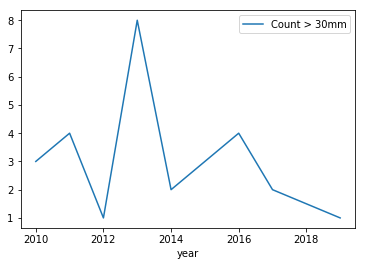

In [21]:
rainy_days.query('totalPrecipMM > 30').groupby(['year']).size().rename('Count > 30mm').to_frame().plot();

2013 saw the most extreme precipitation events (> 30mm precipitation).

### Remove outliers

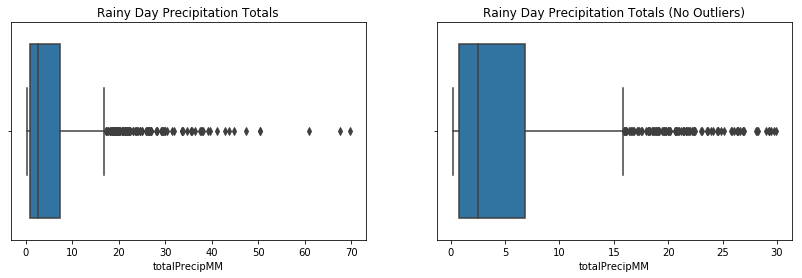

In [22]:
rainy_days_no = rainy_days.query('totalPrecipMM < 30')

plt.figure(figsize=(14,4))
plt.subplot(121);
sns.boxplot(rainy_days['totalPrecipMM']).set(title='Rainy Day Precipitation Totals');
plt.subplot(122);
sns.boxplot(rainy_days_no['totalPrecipMM']).set(title='Rainy Day Precipitation Totals (No Outliers)');

### By year

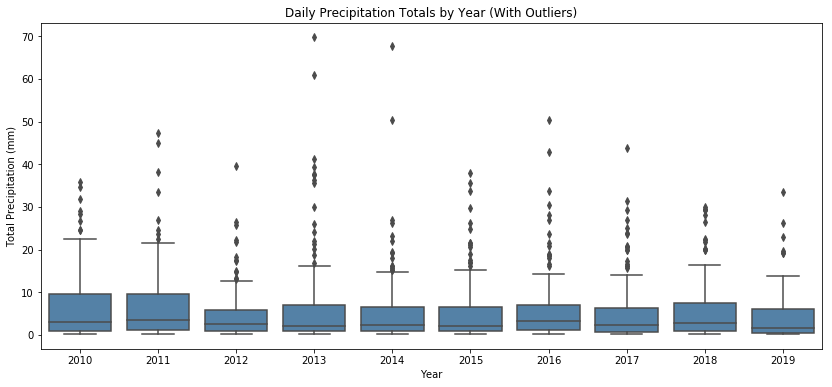

In [117]:
plt.figure(figsize=(14,6))
sns.boxplot(x='year', y='totalPrecipMM', data=rainy_days, color='steelblue').set(
  title='Daily Precipitation Totals by Year (With Outliers)',
  xlabel='Year',
  ylabel='Total Precipitation (mm)'
);

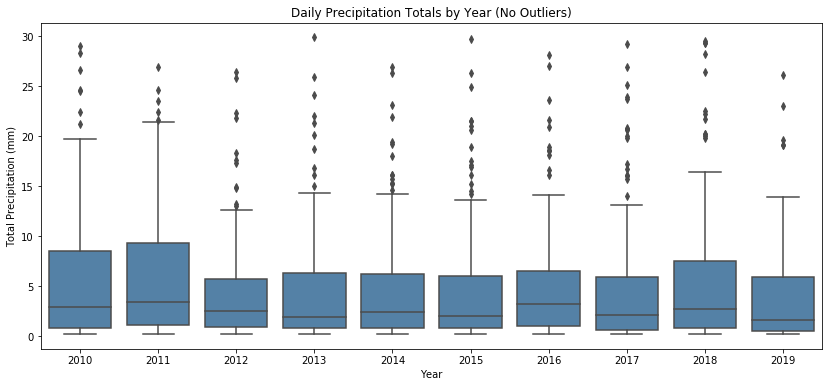

In [23]:
plt.figure(figsize=(14,6))
sns.boxplot(x='year', y='totalPrecipMM', data=rainy_days_no, color='steelblue').set(
  title='Daily Precipitation Totals by Year (No Outliers)',
  xlabel='Year',
  ylabel='Total Precipitation (mm)'
);

Daily precipitation spread (IQR) was larger and the median was higher in 2010, 2011, and 2018 compared to other years. Was it particularly rainy in certain months or throughout the entire year?

In [24]:
rainy_day_stats_by_year = rainy_days_no.groupby(['year']).totalPrecipMM.describe()
rainy_day_stats_by_year.style.bar(subset=['mean', 'std'])

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2010,145,5.91621,6.76802,0.2,0.8,2.9,8.5,29
2011,180,5.73694,5.94492,0.2,1.1375,3.45,9.275,26.9
2012,164,4.24543,5.00687,0.2,0.9,2.5,5.7125,26.4
2013,184,4.37609,5.46128,0.2,0.75,1.9,6.35,29.9
2014,169,4.61686,5.50328,0.2,0.8,2.4,6.25,26.9
2015,143,4.7549,6.12682,0.2,0.8,2,6,29.7
2016,162,5.05432,5.62815,0.2,1.0125,3.225,6.5,28.1
2017,191,4.51859,5.87152,0.2,0.6,2.15,5.875,29.25
2018,177,5.33616,6.51331,0.2,0.8,2.7,7.5,29.5


It's interesting to see that 2017 (a year of extreme precipitation) doesn't stand out in terms of daily observed precipitation. What about in terms of weekly totals? Intuitively, we are going to notice longer-term trends more than shorter-term trends. For example, we may not notice small amounts of variation of the amount of precipitation we get each day, but rather the aggregate of all rain in a week or the frequency in which we are experiencing it.

### By month

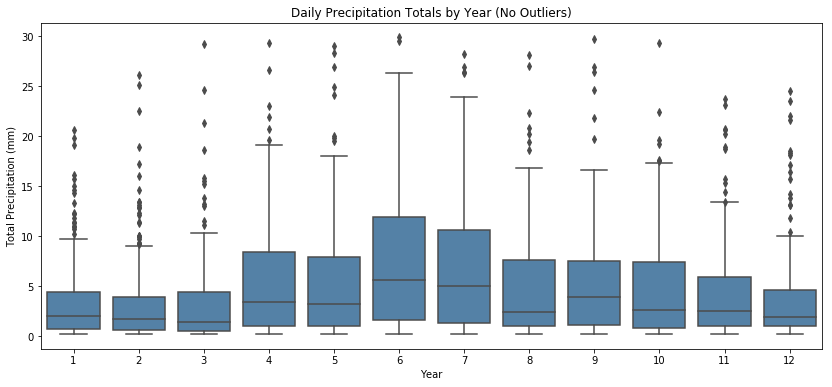

In [25]:
plt.figure(figsize=(14,6))
sns.boxplot(x='month', y='totalPrecipMM', data=rainy_days_no, color='steelblue').set(
  title='Daily Precipitation Totals by Year (No Outliers)',
  xlabel='Year',
  ylabel='Total Precipitation (mm)'
);

* January - March distributions are relatively similar with more extreme observations in February and March
* April - July vary the most
* June appears to have the most erratic precipitation
* August - October ditributions are relatively similar

## How much rain is expected weekly?

In [61]:
rainy_days_weekly = (
  rainy_days
    .set_index('date')
    .resample('1W')['totalPrecipMM']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'totalPrecipMM', 'count': 'rainyDays'})
    .assign(date=lambda x: pd.to_datetime(x.index))
    .assign(year=lambda x: x.date.dt.year)
    .assign(month=lambda x: x.date.dt.month)
)
rainy_days_weekly.head()

,totalPrecipMM,rainyDays,date,year,month
date,,,,,
2010-01-03,10.10,3,2010-01-03,2010,1
2010-01-10,8.55,4,2010-01-10,2010,1
2010-01-17,1.45,1,2010-01-17,2010,1
2010-01-24,11.60,2,2010-01-24,2010,1
2010-01-31,7.05,6,2010-01-31,2010,1


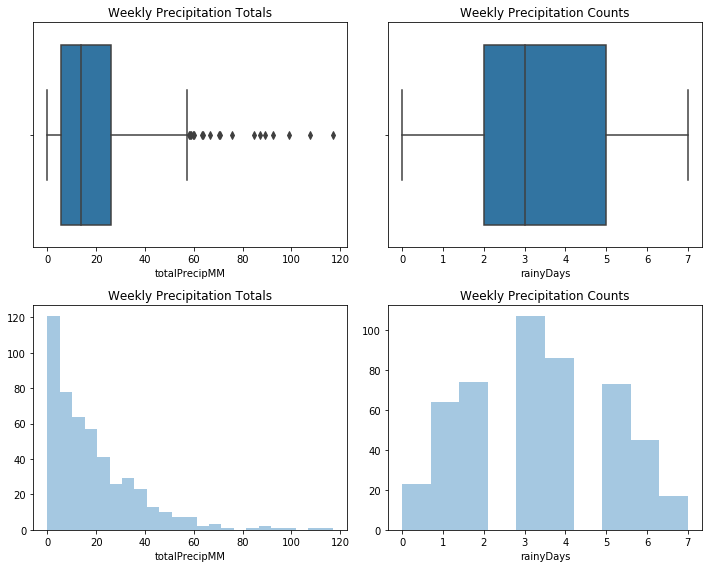

In [62]:
plt.figure(figsize=(10,8))
plt.subplot(221);
sns.boxplot(rainy_days_weekly['totalPrecipMM']).set(title='Weekly Precipitation Totals');
plt.subplot(222);
sns.boxplot(rainy_days_weekly['rainyDays']).set(title='Weekly Precipitation Counts');

plt.subplot(223);
sns.distplot(rainy_days_weekly['totalPrecipMM'], kde=False).set(title='Weekly Precipitation Totals');
plt.subplot(224);
sns.distplot(rainy_days_weekly['rainyDays'], kde=False).set(title='Weekly Precipitation Counts');
plt.tight_layout();

In [63]:
rainy_days_weekly[['rainyDays', 'totalPrecipMM']].describe()

,rainyDays,totalPrecipMM
count,489.000000,489.000000
mean,3.335378,18.484356
std,1.774707,18.029612
min,0.000000,0.000000
25%,2.000000,5.350000
50%,3.000000,13.850000
75%,5.000000,26.200000
max,7.000000,117.100000


The weekly precipitation total distribution is right skewed and bimodal with a second mode at around 35mm / week. 50% of the time, there are three or less rainy days in a week and 75% there are five or less.

## How much rain is expected monthly?

In [97]:
rainy_days_monthly = (
  rainy_days_no
    .set_index('date')
    .resample('1M')['totalPrecipMM']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'totalPrecipMM', 'count': 'rainyDays'})
    .assign(date=lambda x: pd.to_datetime(x.index))
    .assign(year=lambda x: x.date.dt.year)
    .assign(month=lambda x: x.date.dt.month)
)
rainy_days_monthly.head()

,totalPrecipMM,rainyDays,date,year,month
date,,,,,
2010-01-31,38.75,16,2010-01-31,2010,1
2010-02-28,33.45,13,2010-02-28,2010,2
2010-03-31,34.65,7,2010-03-31,2010,3
2010-04-30,76.80,10,2010-04-30,2010,4
2010-05-31,114.20,11,2010-05-31,2010,5


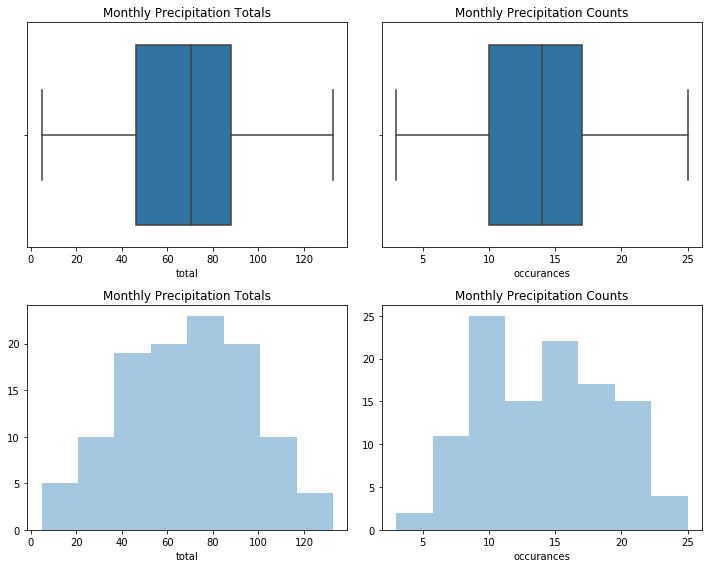

In [140]:
plt.figure(figsize=(10,8))
plt.subplot(221);
sns.boxplot(rainy_days_monthly.total).set(title='Monthly Precipitation Totals');
plt.subplot(222);
sns.boxplot(rainy_days_monthly.occurances).set(title='Monthly Precipitation Counts');

plt.subplot(223);
sns.distplot(rainy_days_monthly.total, kde=False).set(title='Monthly Precipitation Totals');
plt.subplot(224);
sns.distplot(rainy_days_monthly.occurances, kde=False).set(title='Monthly Precipitation Counts');
plt.tight_layout();

The distributions are much more normal at the monthly level and occurances are bimodal which are likely due to seasonality.

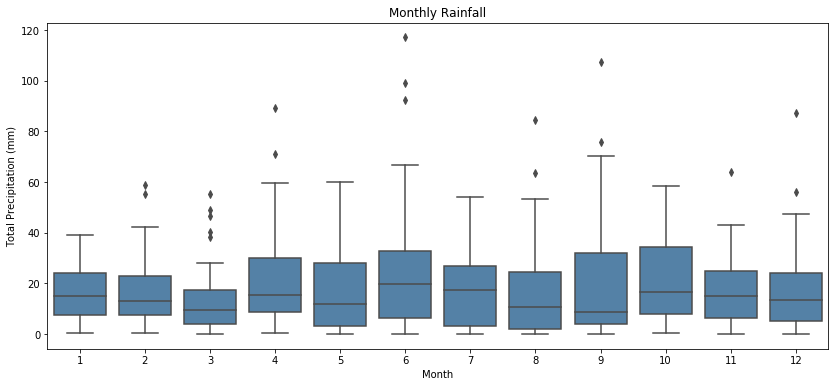

In [104]:
plt.figure(figsize=(14,6))
sns.boxplot(x=rainy_days_weekly['month'], y=rainy_days_weekly['totalPrecipMM'], color='steelblue').set(
  title='Monthly Rainfall',
  xlabel='Month',
  ylabel='Total Precipitation (mm)'
);

We have definitely seen more rain on same days than in entire months.

## How often does it rain?

### By year

In [26]:
today = datetime.now().date()
month, day = today.month, today.day
ytd_filter = 'month <= {}'.format(month)

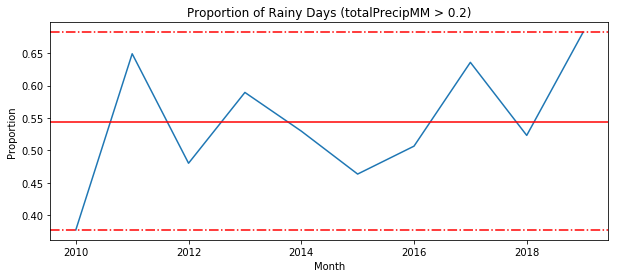

In [27]:
precip_props_by_month = (rainy_days.query(ytd_filter).groupby('year').size() / df.query(ytd_filter).groupby('year').size())
precip_props_by_month.plot(figsize=(10,4)).set(
  title='Proportion of Rainy Days (totalPrecipMM >= 0.2)',
  xlabel='Month',
  ylabel='Proportion'
);
plt.axhline(precip_props_by_month.mean(), color='red', linestyle='-');
plt.axhline(precip_props_by_month.min(), color='red', linestyle='-.');
plt.axhline(precip_props_by_month.max(), color='red', linestyle='-.');

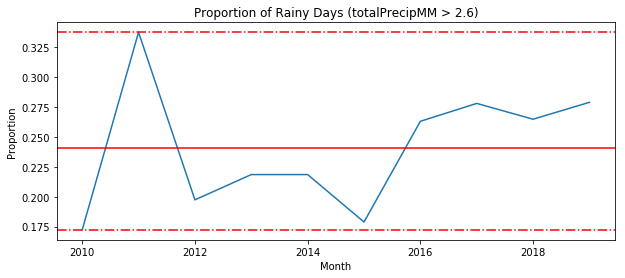

In [28]:
precip_props_by_month = (rainy_days.query(ytd_filter + ' & totalPrecipMM > 2.6').groupby('year').size() / df.query(ytd_filter).groupby('year').size())
precip_props_by_month.plot(figsize=(10,4)).set(
  title='Proportion of Rainy Days (totalPrecipMM > 2.6)',
  xlabel='Month',
  ylabel='Proportion'
);
plt.axhline(precip_props_by_month.mean(), color='red', linestyle='-');
plt.axhline(precip_props_by_month.min(), color='red', linestyle='-.');
plt.axhline(precip_props_by_month.max(), color='red', linestyle='-.');

Extreme rain events have been more consistent over the last few years than rain events in general.

### By month

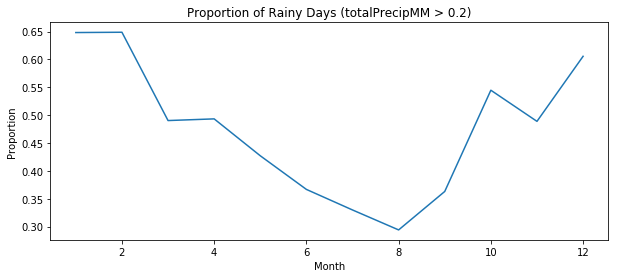

In [29]:
precip_props_by_month = (rainy_days.groupby('month').size() / df.groupby('month').size())
precip_props_by_month.plot(figsize=(10,4)).set(
  title='Proportion of Rainy Days (totalPrecipMM >= 0.2)',
  xlabel='Month',
  ylabel='Proportion'
);

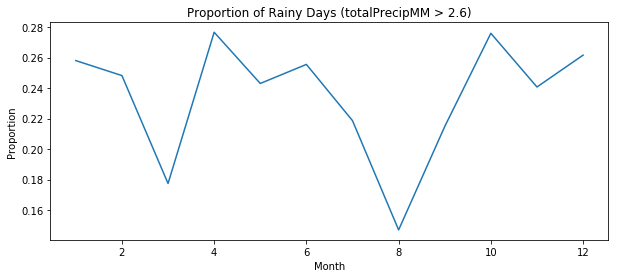

In [30]:
precip_props_by_month = (rainy_days.query('totalPrecipMM > 2.6').groupby('month').size() / df.groupby('month').size())
precip_props_by_month.plot(figsize=(10,4)).set(
  title='Proportion of Rainy Days (totalPrecipMM > 2.6)',
  xlabel='Month',
  ylabel='Proportion'
);

The proportion of rain events with precipitation measurements above the median is consistent except for sharp drops in March and August.

## Can we discern rainy days from snowy days?

Rainy days in winter months are likely precipitation measurements from snowfall. We can heuristically remove days with both snow and rain, providing snow measurements are not significantly missing for winter months.

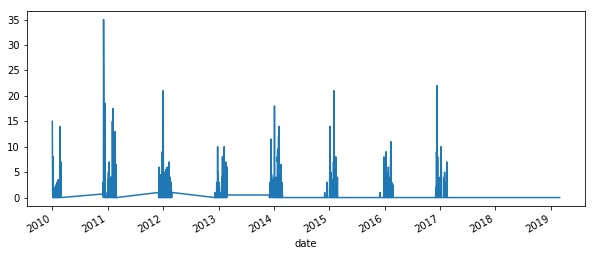

In [31]:
df.set_index('date').query('(season == "winter")')['totalSnowCM'].fillna(0).plot(figsize=(10,4));

We are missing snowfall data after 2017. How does snowfall correlate with precipitation in winter months?

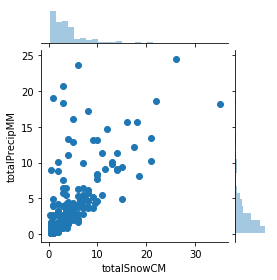

In [32]:
winter_rainy_days = rainy_days.query('(season=="winter") & (date < "2018-01-01") & (totalSnowCM > 0)')
sns.jointplot(
  x="totalSnowCM", y="totalPrecipMM", 
  data=winter_rainy_days, size=4);

It's likely that we would observe days with larger precipitation than snowfall values since (1) it can rain and snow in a day and (2) precipitation may be disproportionate to snowfall depending on the density of the snow and the temperature. If it's hotter out, snow will melt leading to higher precipitation values.

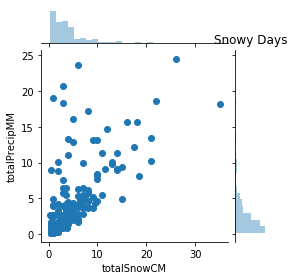

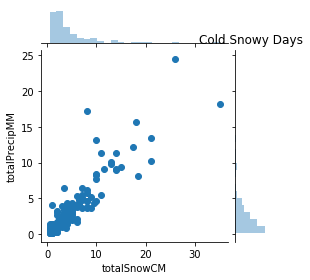

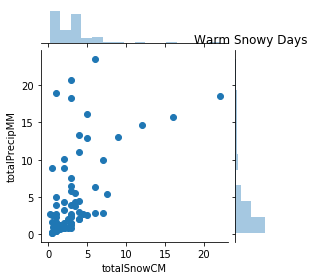

In [33]:
winter_rainy_days = rainy_days.query('(season=="winter") & (date < "2018-01-01")')

snowy_days = winter_rainy_days.query('totalSnowCM > 0')
snowy_cold_days = snowy_days.query('maxTemp < 0')
snowy_warm_days = snowy_days.query('maxTemp > 0')

sns.jointplot(
  x="totalSnowCM", y="totalPrecipMM", 
  data=snowy_days, size=4)
plt.title('Snowy Days')

sns.jointplot(
  x="totalSnowCM", y="totalPrecipMM", 
  data=snowy_cold_days, size=4);
plt.title('Cold Snowy Days')

sns.jointplot(
  x="totalSnowCM", y="totalPrecipMM", 
  data=snowy_warm_days, size=4);
plt.title('Warm Snowy Days');

In [34]:
snowy_days[['totalSnowCM', 'totalPrecipMM']].corr(method='spearman')

,totalSnowCM,totalPrecipMM
totalSnowCM,1.000000,0.778524
totalPrecipMM,0.778524,1.000000


In [35]:
snowy_cold_days[['totalSnowCM', 'totalPrecipMM']].corr(method='spearman')

,totalSnowCM,totalPrecipMM
totalSnowCM,1.000000,0.897205
totalPrecipMM,0.897205,1.000000


In [37]:
snowy_warm_days[['totalSnowCM', 'totalPrecipMM']].corr(method='spearman')

,totalSnowCM,totalPrecipMM
totalSnowCM,1.00000,0.57995
totalPrecipMM,0.57995,1.00000


Disproportionately larger precipitation values, when compared to snow values, could be caused by precipitation in addition to rain (in the case of days with an observed high above zero degrees celsius) or "wetter" snow (see [4]). Rather than come up with methods for predicting snow vs. rain, can simply exclude winter (or rather days with observed lows below zero) from our modelling.

## How many times in a week does it rain?

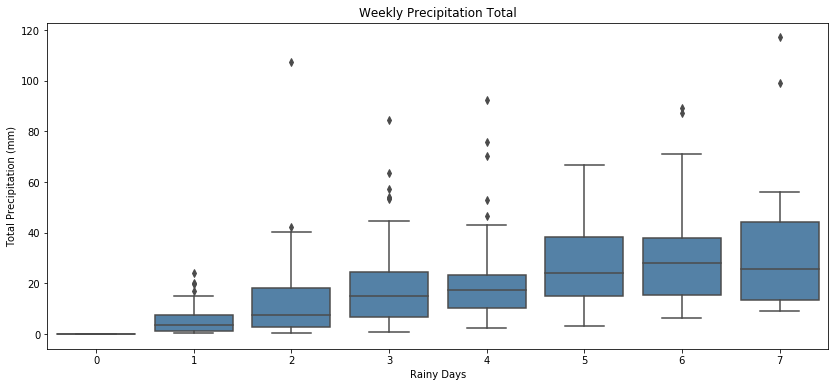

In [64]:
plt.figure(figsize=(14,6))
sns.boxplot(x=rainy_days_weekly['rainyDays'], y=rainy_days_weekly['totalPrecipMM'], color='steelblue').set(
  title='Weekly Precipitation Total',
  xlabel='Rainy Days',
  ylabel='Total Precipitation (mm)'
);

There is generally more variance in precipitation over more observed rainy days which makes sense as more rain events does not necessarily mean that there was more precipitation. It's interesting to see that in one week with two rain events, more than ~110mm of rain was observed.

In [65]:
rainy_days_weekly.query('totalPrecipMM > 100')

,totalPrecipMM,rainyDays,date,year,month
date,,,,,
2010-06-06,117.1,7,2010-06-06,2010,6
2013-09-22,107.4,2,2013-09-22,2013,9


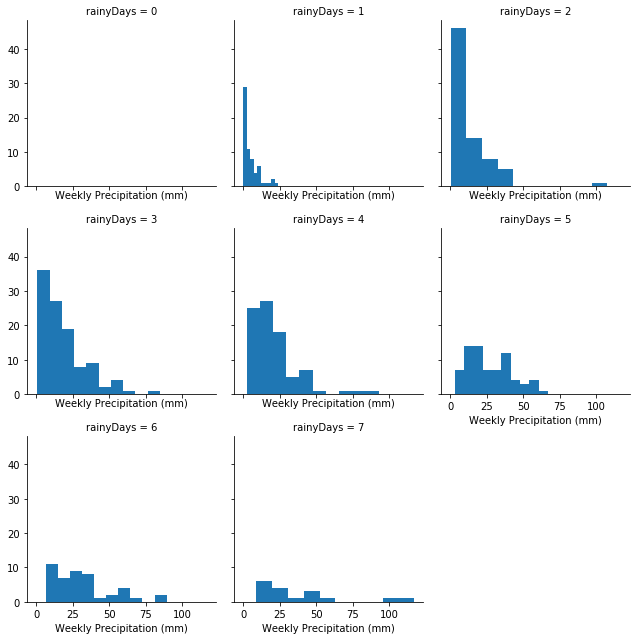

In [66]:
g = sns.FacetGrid(rainy_days_weekly, col='rainyDays', col_wrap=3)
g = g.map(plt.hist, 'totalPrecipMM').set(xlabel='Weekly Precipitation (mm)');

In [73]:
rainy_days_weekly.groupby('rainyDays')['totalPrecipMM'].describe().style.bar(subset=['mean', 'std', 'max'])

,count,mean,std,min,25%,50%,75%,max
rainyDays,,,,,,,,
0,23,0,0,0,0,0,0,0
1,64,5.18984,5.47025,0.2,1.1,3.5,7.325,23.9
2,74,12.6912,15.6257,0.4,2.65,7.4,18.1125,107.4
3,107,18.6664,15.5644,0.9,6.65,15.1,24.6,84.6
4,86,20.414,15.9506,2.4,10.125,17.25,23.4,92.6
5,73,27.1945,15.3369,3.3,15,24.2,38.4,66.8
6,45,31.4622,20.867,6.4,15.25,28,38,89.25
7,17,36.0971,30.7776,9,13.3,25.6,44.2,117.1


Without outliers

In [76]:
rainy_day_stats = rainy_days_weekly['totalPrecipMM'].describe()
rainy_day_stats_upper = rainy_day_stats['75%'] + 1.5 * (rainy_day_stats['75%'] - rainy_day_stats['25%'])
print('Outlier threshold:', rainy_day_stats_upper)

Outlier threshold: 57.47500000000001


In [77]:
rainy_days_weekly_no = rainy_days_weekly.query('totalPrecipMM < {}'.format(rainy_day_stats_upper))
rainy_days_weekly_no.groupby('rainyDays')['totalPrecipMM'].describe().style.bar(subset=['mean', 'std', 'max'])

,count,mean,std,min,25%,50%,75%,max
rainyDays,,,,,,,,
0,23,0,0,0,0,0,0,0
1,64,5.18984,5.47025,0.2,1.1,3.5,7.325,23.9
2,73,11.3938,11.0121,0.4,2.6,7,17.7,42.1
3,105,17.6124,13.5921,0.9,6.6,15.1,23.9,57.2
4,83,18.2795,11.3222,2.4,9.7,16.8,22.85,53.1
5,70,25.7207,13.8285,3.3,14.775,22.825,37.9,55.5
6,38,24.4118,12.6786,6.4,14.0375,25.025,32.875,55.3
7,15,26.5033,15.2534,9,12.7,23.95,38.875,56.25


Average precipitation is consistent accross 5-7 rainy days.

### Extreme events
Extreme rain events with weeks with an observed precipitation level that is greater than 1.5x the IQR (75th - 25th percentile).

In [90]:
rainy_days_weekly_o = rainy_days_weekly.query('totalPrecipMM >= {}'.format(rainy_day_stats_upper))
rainy_days_weekly_o.groupby('rainyDays').size().sort_values(ascending=False)

rainyDays
6    7
5    3
4    3
7    2
3    2
2    1
dtype: int64

There has never been an extreme rain event where it rained only one day in a week. So any single-day rain event with observed precipitation greater than the threshold would have occurred in a week during which it rained more than once.

In [80]:
outliers = (
  rainy_days_weekly_o
    .assign(date=lambda x: pd.to_datetime(x.index))
    .assign(year=lambda x: x.date.dt.year)
    .assign(month=lambda x: x.date.dt.month)
)
outliers.groupby(['year', 'month']).size()

year  month
2010  4        1
      6        1
2011  12       1
2013  2        1
      4        1
      6        1
      9        1
      10       1
2014  9        2
2015  6        1
2016  4        1
      8        2
2017  5        1
2018  6        1
      11       1
2019  4        1
dtype: int64

Aside from 2013, extreme weekly rain events happen 1-2 times per year.

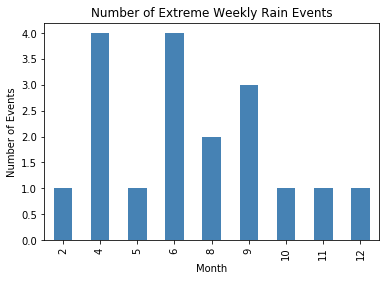

In [91]:
outliers.groupby('month').size().plot(kind='bar', color='steelblue').set(
  title='Number of Extreme Weekly Rain Events',
  xlabel='Month',
  ylabel='Number of Events'
);

May and June are associated the highest number of extreme weekly rain events.

### By week and year

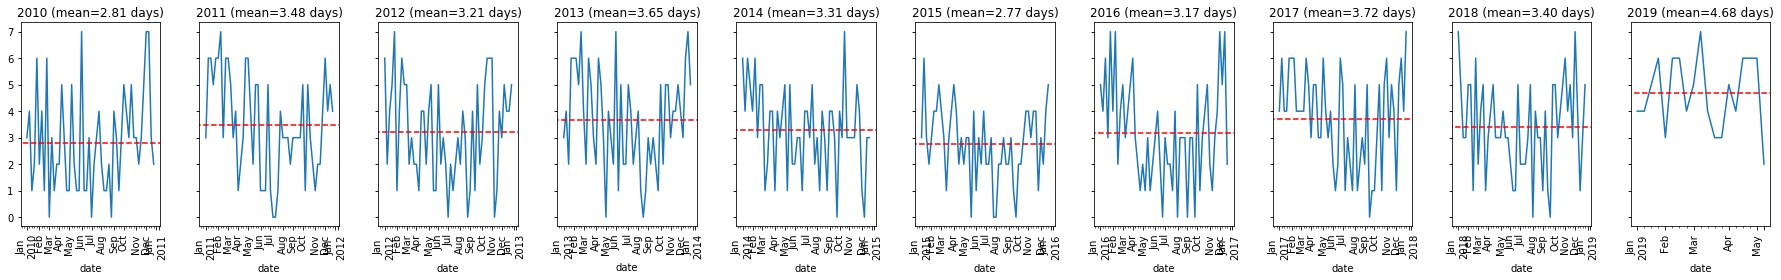

In [87]:
fig, ax = plt.subplots(1, 10, sharey=True, figsize=(25,4))
month = datetime.today().month
for i, y in enumerate(range(2010, 2020)):
  d = rainy_days_weekly.query("(year == {})".format(y))['rainyDays']
  _ = d.plot(ax=ax[i], rot=90)
  _.axhline(y=d.mean(), xmin=-1, xmax=1, c="red", linewidth=1.5, linestyle="--")
  _.set_title("{} (mean={:.2f} days)".format(y, d.mean()))
plt.tight_layout();

### Weekly average by year and month

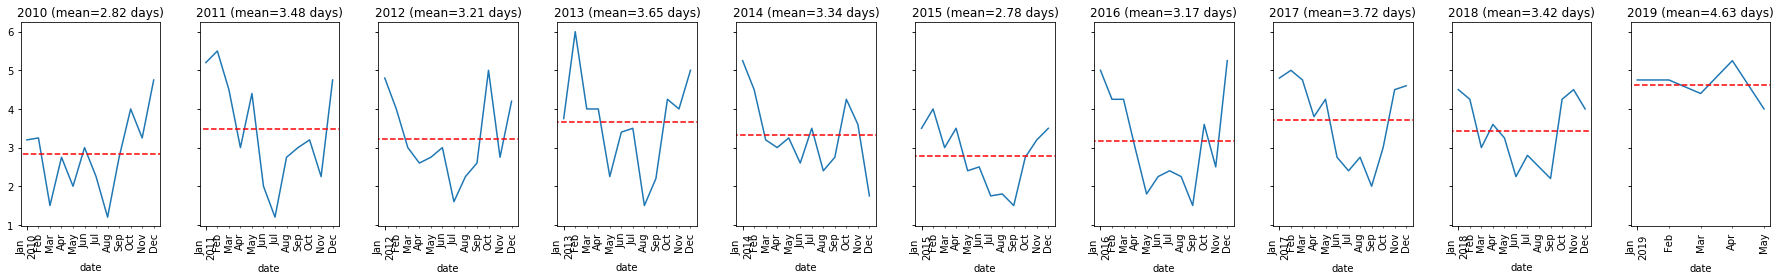

In [89]:
fig, ax = plt.subplots(1, 10, sharey=True, figsize=(25,4))
month = datetime.today().month
for i, y in enumerate(range(2010, 2020)):
  d = rainy_days_weekly.query("(year == {})".format(y)).resample('1M')['rainyDays'].mean()
  _ = d.plot(ax=ax[i], rot=90)
  _.axhline(y=d.mean(), xmin=-1, xmax=1, c="red", linewidth=1.5, linestyle="--")
  _.set_title("{} (mean={:.2f} days)".format(y, d.mean()))
plt.tight_layout();

While there are some years with exceptions, both the weekly and average weekly rain day counts appear U-shaped, exhibiting seasonality that aligns with the rain distributions.

### Weekly average by month and year

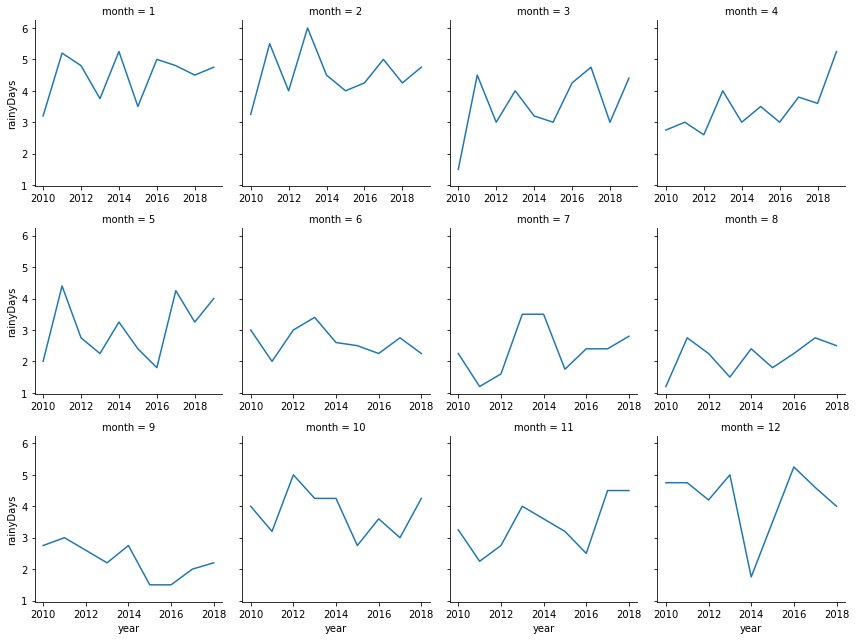

In [95]:
weekly_rainy_day_counts = rainy_days_weekly.groupby(['year', 'month'])['rainyDays'].mean().reset_index()
g = sns.FacetGrid(weekly_rainy_day_counts, col='month', col_wrap=4, sharex=False)
g = g.map(plt.plot, 'year', 'rainyDays');

We've seen a general upward trend in weekly rainy events in April and November with the highest April average in the last ten years.

## How many times in a month does it rain?

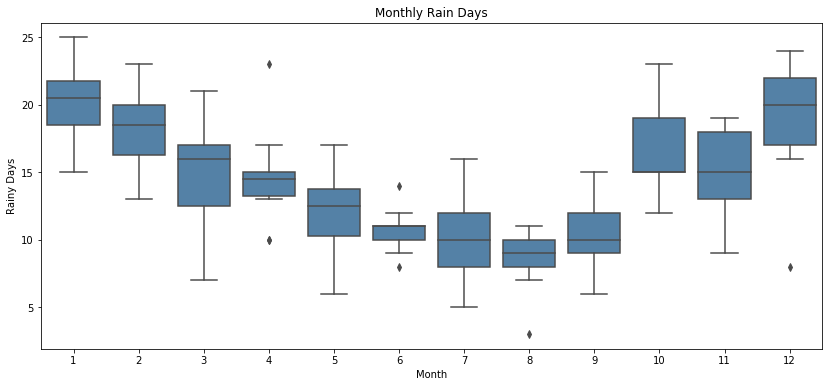

In [98]:
plt.figure(figsize=(14,6))
sns.boxplot(x=rainy_days_monthly['month'], y=rainy_days_monthly['rainyDays'], color='steelblue').set(
  title='Monthly Rain Days',
  xlabel='Month',
  ylabel='Rainy Days'
);

In [100]:
rainy_days_monthly.groupby('month')['rainyDays'].describe().style.bar(subset=['mean', 'std', 'max'])

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,10,20,2.98142,15,18.5,20.5,21.75,25
2,10,18.3,3.12872,13,16.25,18.5,20,23
3,10,14.9,3.87155,7,12.5,16,17,21
4,10,14.6,3.68782,10,13.25,14.5,15,23
5,10,12.1,3.54181,6,10.25,12.5,13.75,17
6,9,10.6667,1.73205,8,10,11,11,14
7,9,10.1111,3.72305,5,8,10,12,16
8,9,8.55556,2.45515,3,8,9,10,11
9,9,10.1111,2.848,6,9,10,12,15


These results are intuitive - it rains less frequently during the summer months. What's interesting is the drastic difference between September and October as there is a large difference between the means and medians, likely due to seasonality. The change from summer to fall appears to be more dramatic than the change from winter to spring and spring to summer which is an intuitive result since there tends to be more precipitation with the colder weather.

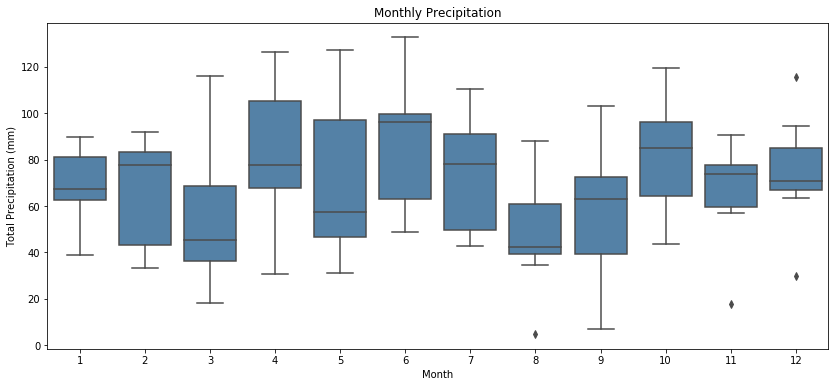

In [101]:
plt.figure(figsize=(14,6))
sns.boxplot(x=rainy_days_monthly['month'], y=rainy_days_monthly['totalPrecipMM'], color='steelblue').set(
  title='Monthly Precipitation',
  xlabel='Month',
  ylabel='Total Precipitation (mm)'
);

In [149]:
rainy_days_monthly.groupby('month')['total'].describe().style.bar(subset=['mean', 'std'])

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,10,69,15.4651,38.75,62.6125,67.55,81.075,89.85
2,10,66.12,23.2731,33.45,43.05,77.875,83.2,92
3,10,49.91,33.1279,5.1,30.975,45.2,68.625,116
4,9,77.7889,24.8976,30.6,65.95,76.8,101,107.2
5,9,71.9222,35.842,31.1,44.3,60.2,102,127.1
6,9,87.1778,28.1282,49,63.1,96.2,99.6,132.7
7,9,75.3778,26.4835,42.8,49.6,78.1,91.1,110.5
8,9,49.0333,26.0658,4.8,39.2,42.4,61,87.9
9,9,58.7556,30.586,7,39.5,63,72.6,103


In [154]:
rainy_days_weekly.groupby('month')['occurances'].describe().style.bar(subset=['mean', 'std'])

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,45,4.48889,1.56121,1,3,4,6,7
2,40,4.525,1.64843,1,4,5,6,7
3,41,3.5122,1.53496,0,2,4,5,6
4,39,3.17949,1.39306,1,2,3,4,6
5,40,2.875,1.65153,0,1.75,3,4,6
6,38,2.55263,1.68775,0,1,2,3,7
7,41,2.31707,1.47375,0,1,2,3,5
8,39,2,1.33771,0,1,2,3,5
9,39,2.12821,1.48996,0,1,2,3,5


[1] https://ec.gc.ca/meteo-weather/default.asp?lang=En&n=B8CD636F-1&def=show02B55773D#wsDT2B55773D

[1] http://glossary.ametsoc.org/wiki/Rain

[2] http://climate.weather.gc.ca/historical_data/search_historic_data_stations_e.html?searchType=stnName&timeframe=1&txtStationName=London&searchMethod=contains&optLimit=yearRange&StartYear=1840&EndYear=2019&Year=2019&Month=2&Day=22&selRowPerPage=25

[3] https://www.int-res.com/articles/cr_oa/c067p071.pdf

[4] http://www.theweatherprediction.com/habyhints2/650/

#### NOTES
* Normals available at http://climate.weather.gc.ca/climate_normals/results_1981_2010_e.html?stnID=4789&autofwd=1